# SPAM Classification Project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import ipywidgets as widgets
import nltk
import re
# plot directly to notebook (ipython magic function)
%matplotlib inline

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

In [2]:
#pip freeze --local > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [4]:
# read data from same directory as this notebook file
df=pd.read_csv('combined_data.csv')

## Data Overview

In [7]:
# check for null entries
df.isnull().sum()

label    0
text     0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
df['label'].value_counts()

label
1    43910
0    39538
Name: count, dtype: int64

## Data Visualization

In [10]:
# visualization styling config
sns.set_theme(
    style="whitegrid",
    palette="tab10",
    rc={
        'figure.dpi': 300,
        # 'figure.figsize': (8, 8),
        'axes.titlesize' : 18,
        'axes.labelsize' : 16,
        'lines.linewidth' : 2,
        'lines.markersize' : 10,
        'xtick.labelsize' : 12,
        'ytick.labelsize' : 12
    }
)

In [11]:
def make_autopct(values):
    def pct_and_val(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return pct_and_val

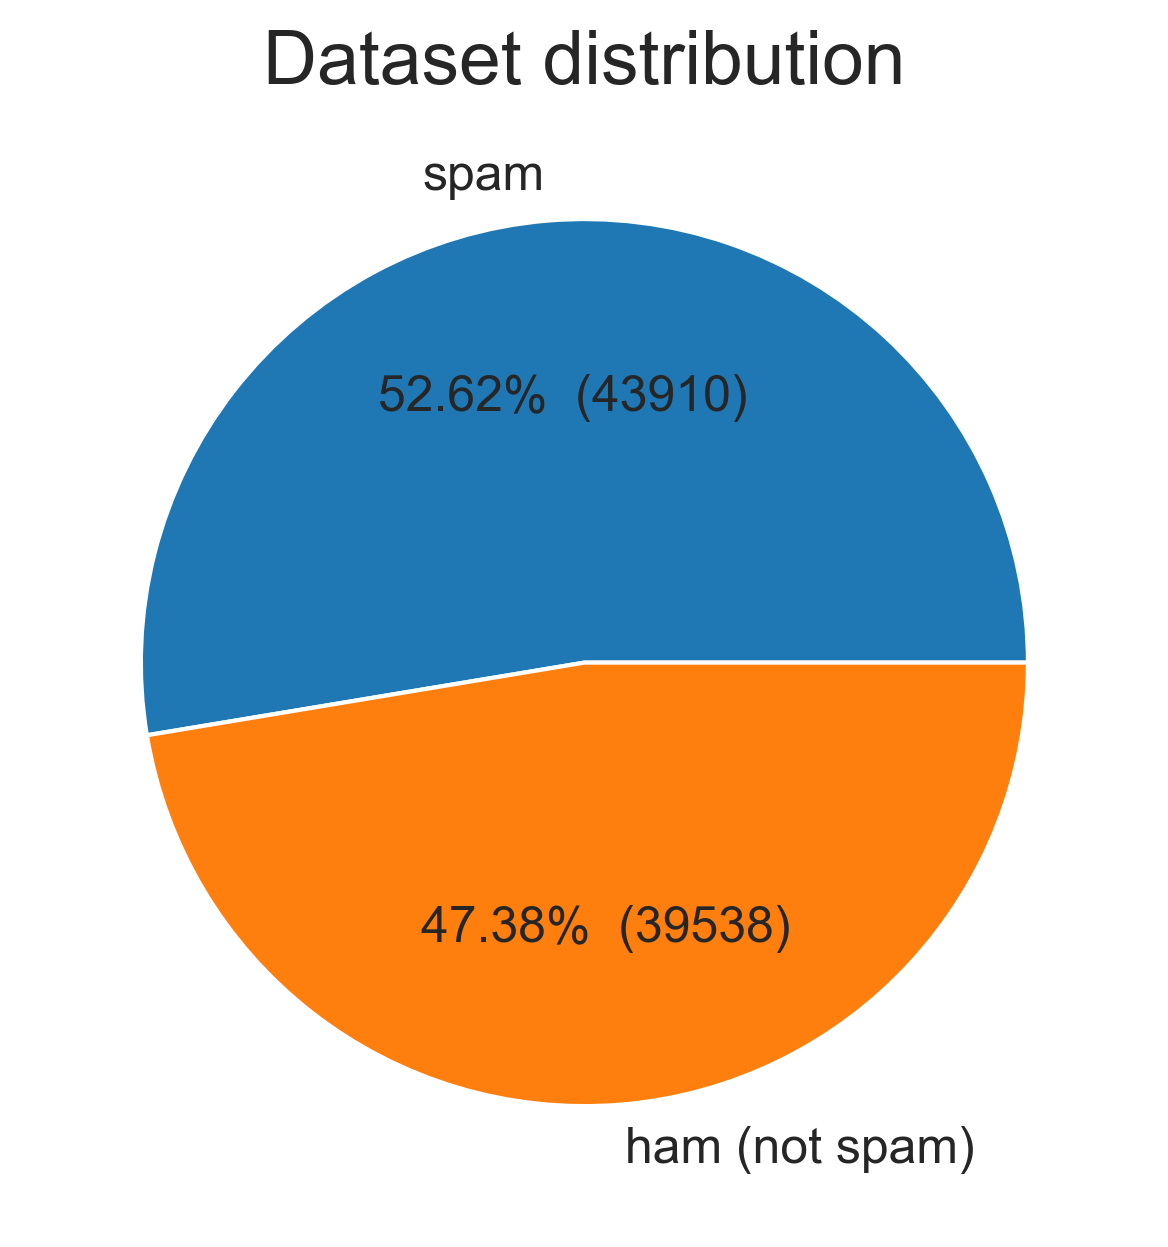

In [12]:
counts=df['label'].value_counts()
plt.pie(counts, labels=['spam','ham (not spam)'], autopct=make_autopct(counts))
plt.title("Dataset distribution")
plt.show()

## Data Preparation
The data has been preprocessed to remove HTML tags, but can do with additional preprocessing, including:
* Removing punctuation
* Lowercasing
* Removing stopwords ("the, as, is") and preprocessing artifacts
* Lemmatization (reducing words to their lemma/stem)

In [48]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/makoto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/makoto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/makoto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
def preprocess(text):
    # build list of unwanted tokens (stopwords, artifacts, etc.)
    punctuation = list(string.punctuation)
    stopwords = nltk.corpus.stopwords.words('english')
    dataset_specific_terms = ['enron']
    bad_tokens = punctuation + stopwords + dataset_specific_terms

    # additional regex to filter tokens containing the following artifacts
    regex = re.compile(r'escapelong|escapenumber|^.{1,2}$')

    # used to convert English words to their lemma/stem form
    lemma = nltk.stem.WordNetLemmatizer()

    # break the text into individual tokens
    tokens = nltk.tokenize.word_tokenize(text)

    # purge numbers
    word_tokens = [t for t in tokens if t.isalpha()]

    # return a lowercased, lemmatized text that contains no punctuation, stopwords, or artifacts
    clean_tokens = [lemma.lemmatize(t.lower()) for t in word_tokens if (t not in bad_tokens) and not regex.search(t)]
    return ' '.join(clean_tokens)

# add a new processed column
df['email'] = df['text'].apply(preprocess)

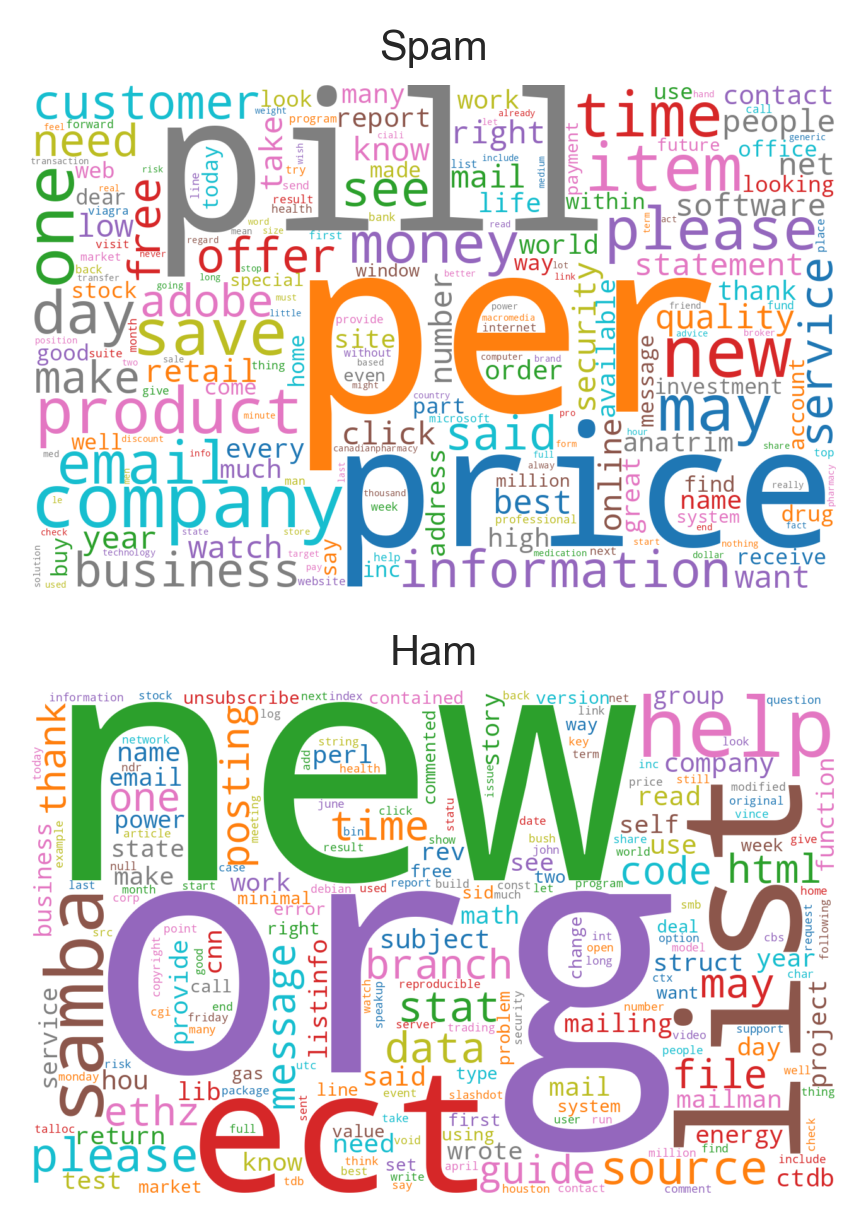

In [49]:
# generate wordmaps
df_spam = df[df['label'] == 1]
df_ham = df[df['label'] == 0]

text_spam = " ".join(text for text in df_spam.email)
text_ham = " ".join(text for text in df_ham.email)

wordcloud_spam = WordCloud(
    width=1280,
    height=800,
    background_color="white",
    colormap="tab10",
    collocations=False
).generate(text_spam)
wordcloud_ham = WordCloud(
    width=1280,
    height=800,
    background_color="white",
    colormap="tab10",
    collocations=False
).generate(text_ham)

fig, (ax1, ax2) = plt.subplots(2)

ax1.set_title("Spam", fontsize=10)
ax1.imshow(wordcloud_spam, interpolation='bilinear')
ax1.axis("off")

ax2.set_title("Ham", fontsize=10)
ax2.imshow(wordcloud_ham, interpolation='bilinear')
ax2.axis("off")

plt.show()

In [25]:
# text vectorization setup
tfidf_vec=TfidfVectorizer(norm=None, max_features=3000)

# vectorize the preprocessed email text
email_tfidf_vec=tfidf_vec.fit_transform(df['email']).toarray()

## Data Processing/Investigation

In [26]:
# Split data into 80% train and 20% test subsets
X_train, X_test, y_train, y_test=train_test_split(email_tfidf_vec, df['label'], test_size = 0.2, random_state=12)

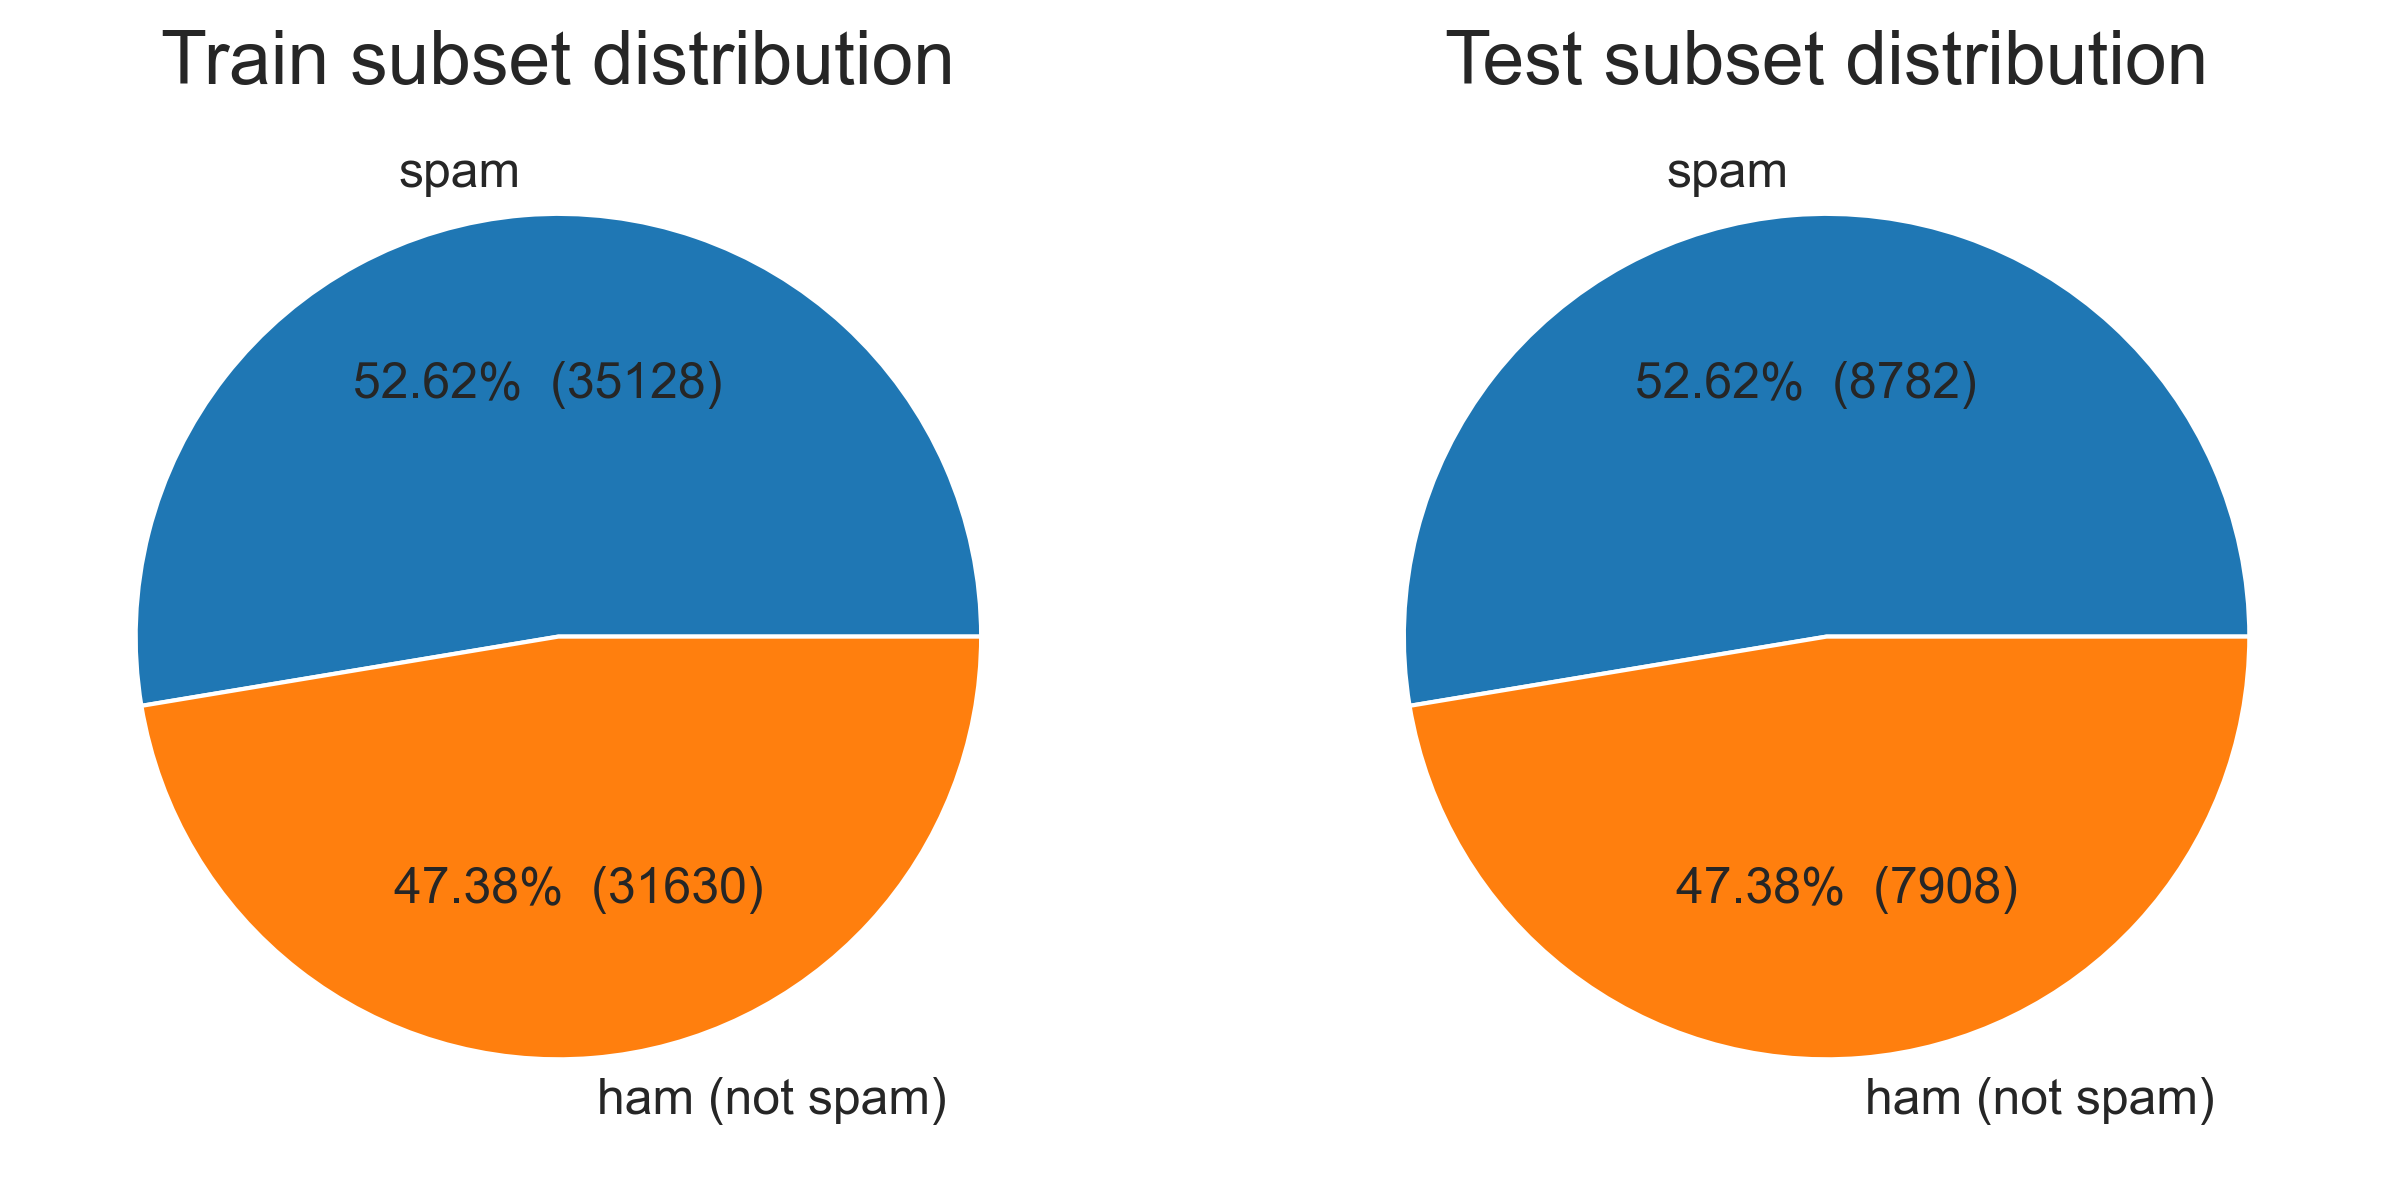

In [27]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)

plt.title("Train subset distribution")
plt.pie(counts, labels=['spam','ham (not spam)'], autopct=make_autopct(y_train.value_counts()))
plt.subplot(1,2,2)

plt.title("Test subset distribution")
plt.pie(counts, labels=['spam','ham (not spam)'], autopct=make_autopct(y_test.value_counts()))
plt.show()

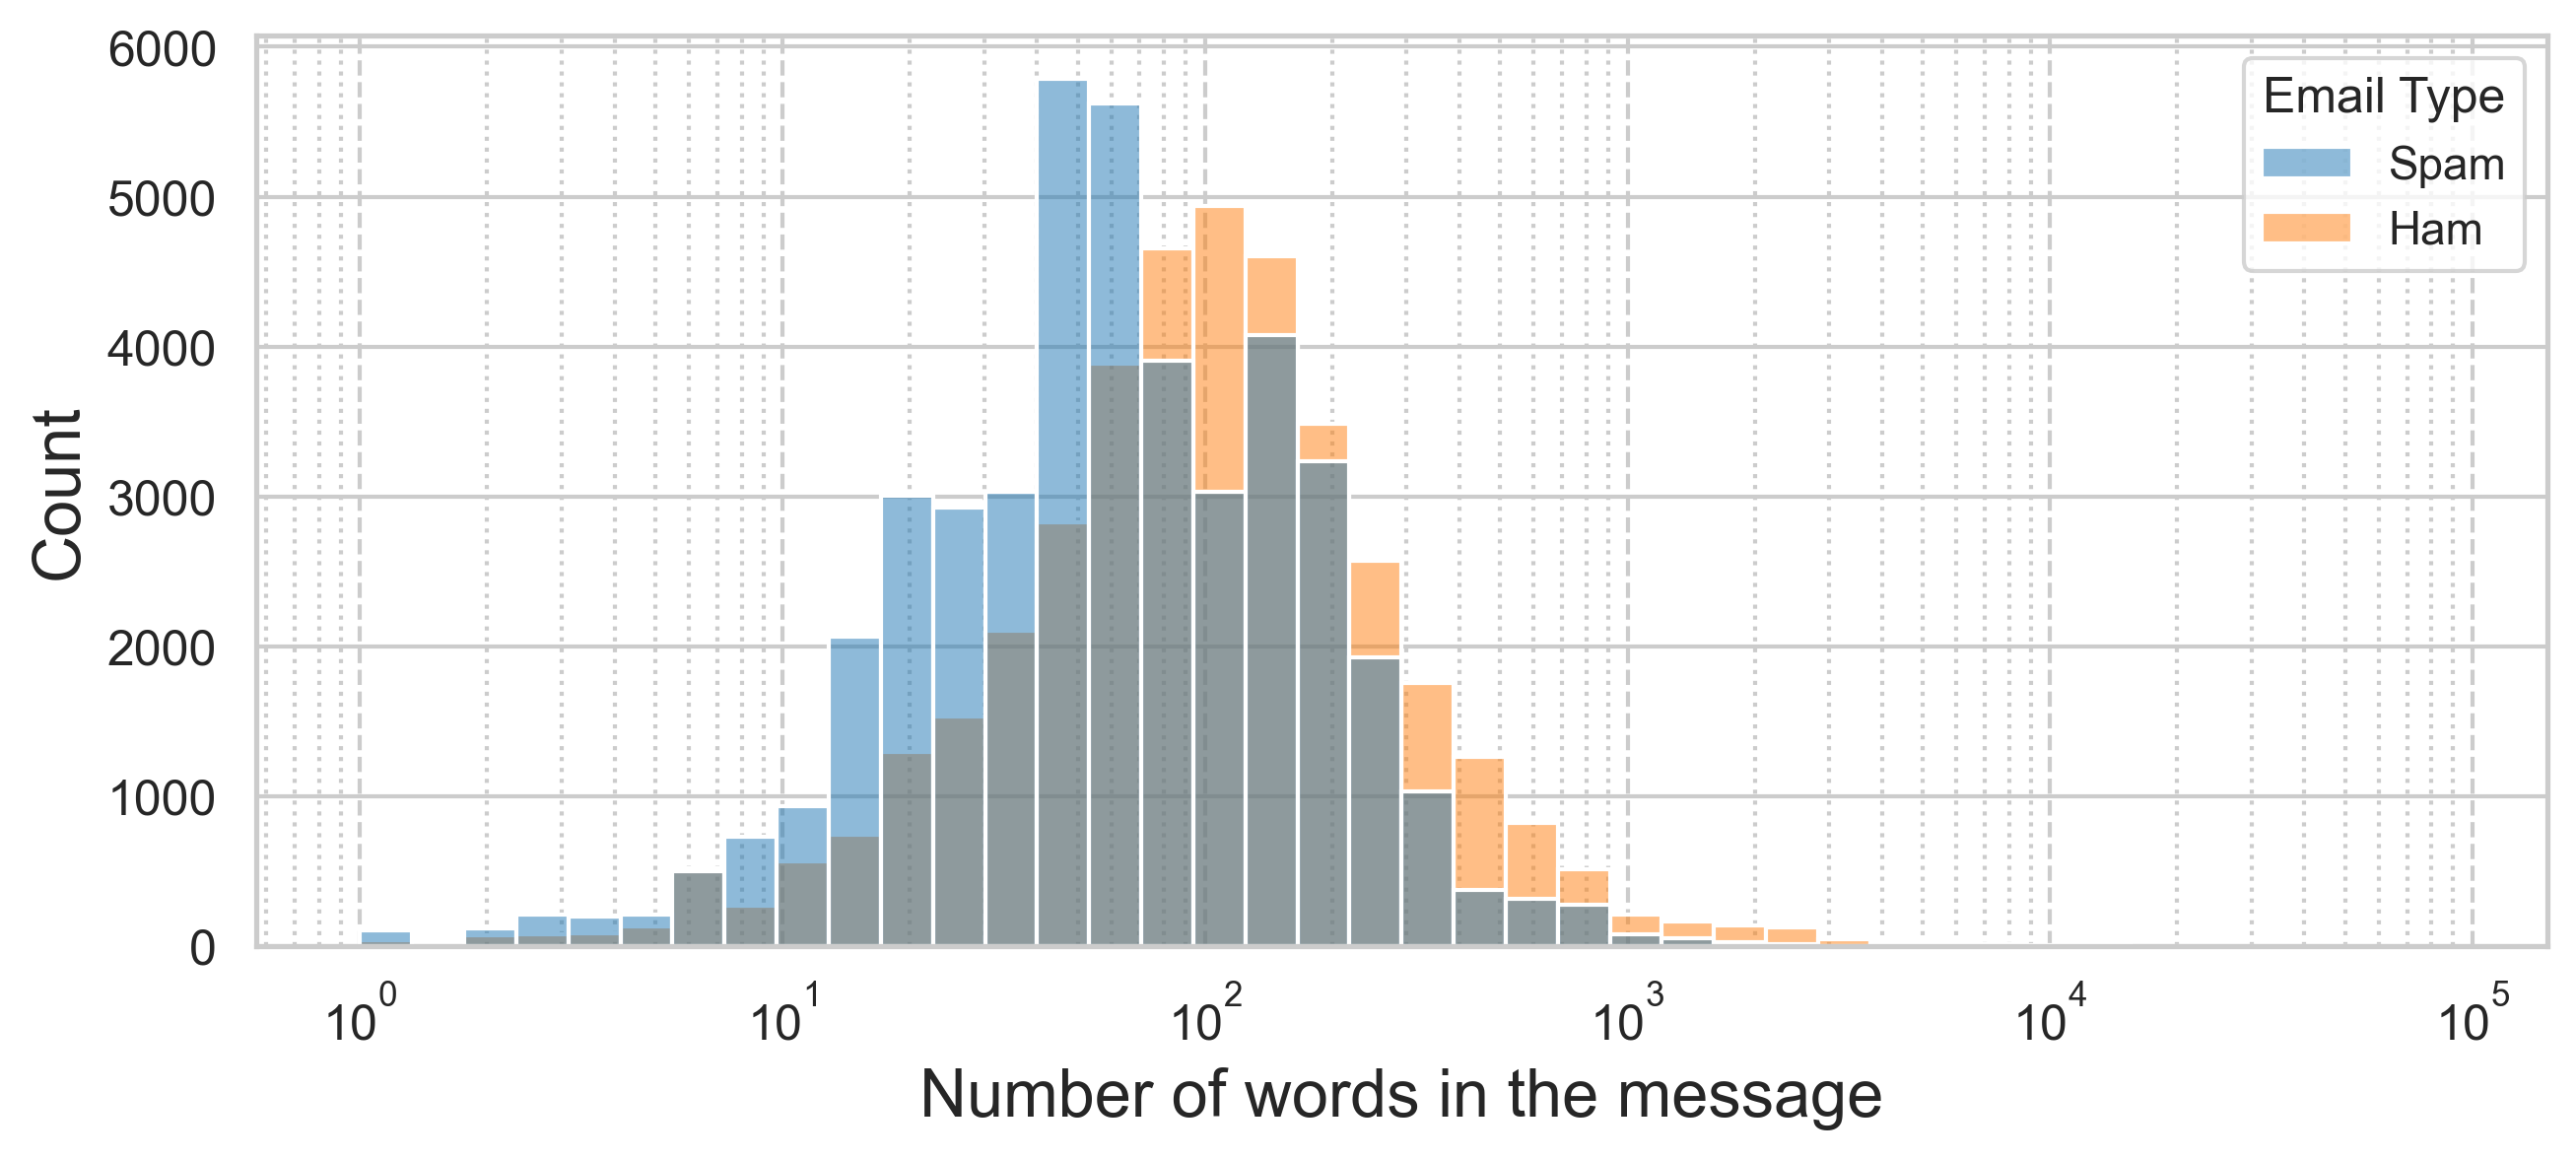

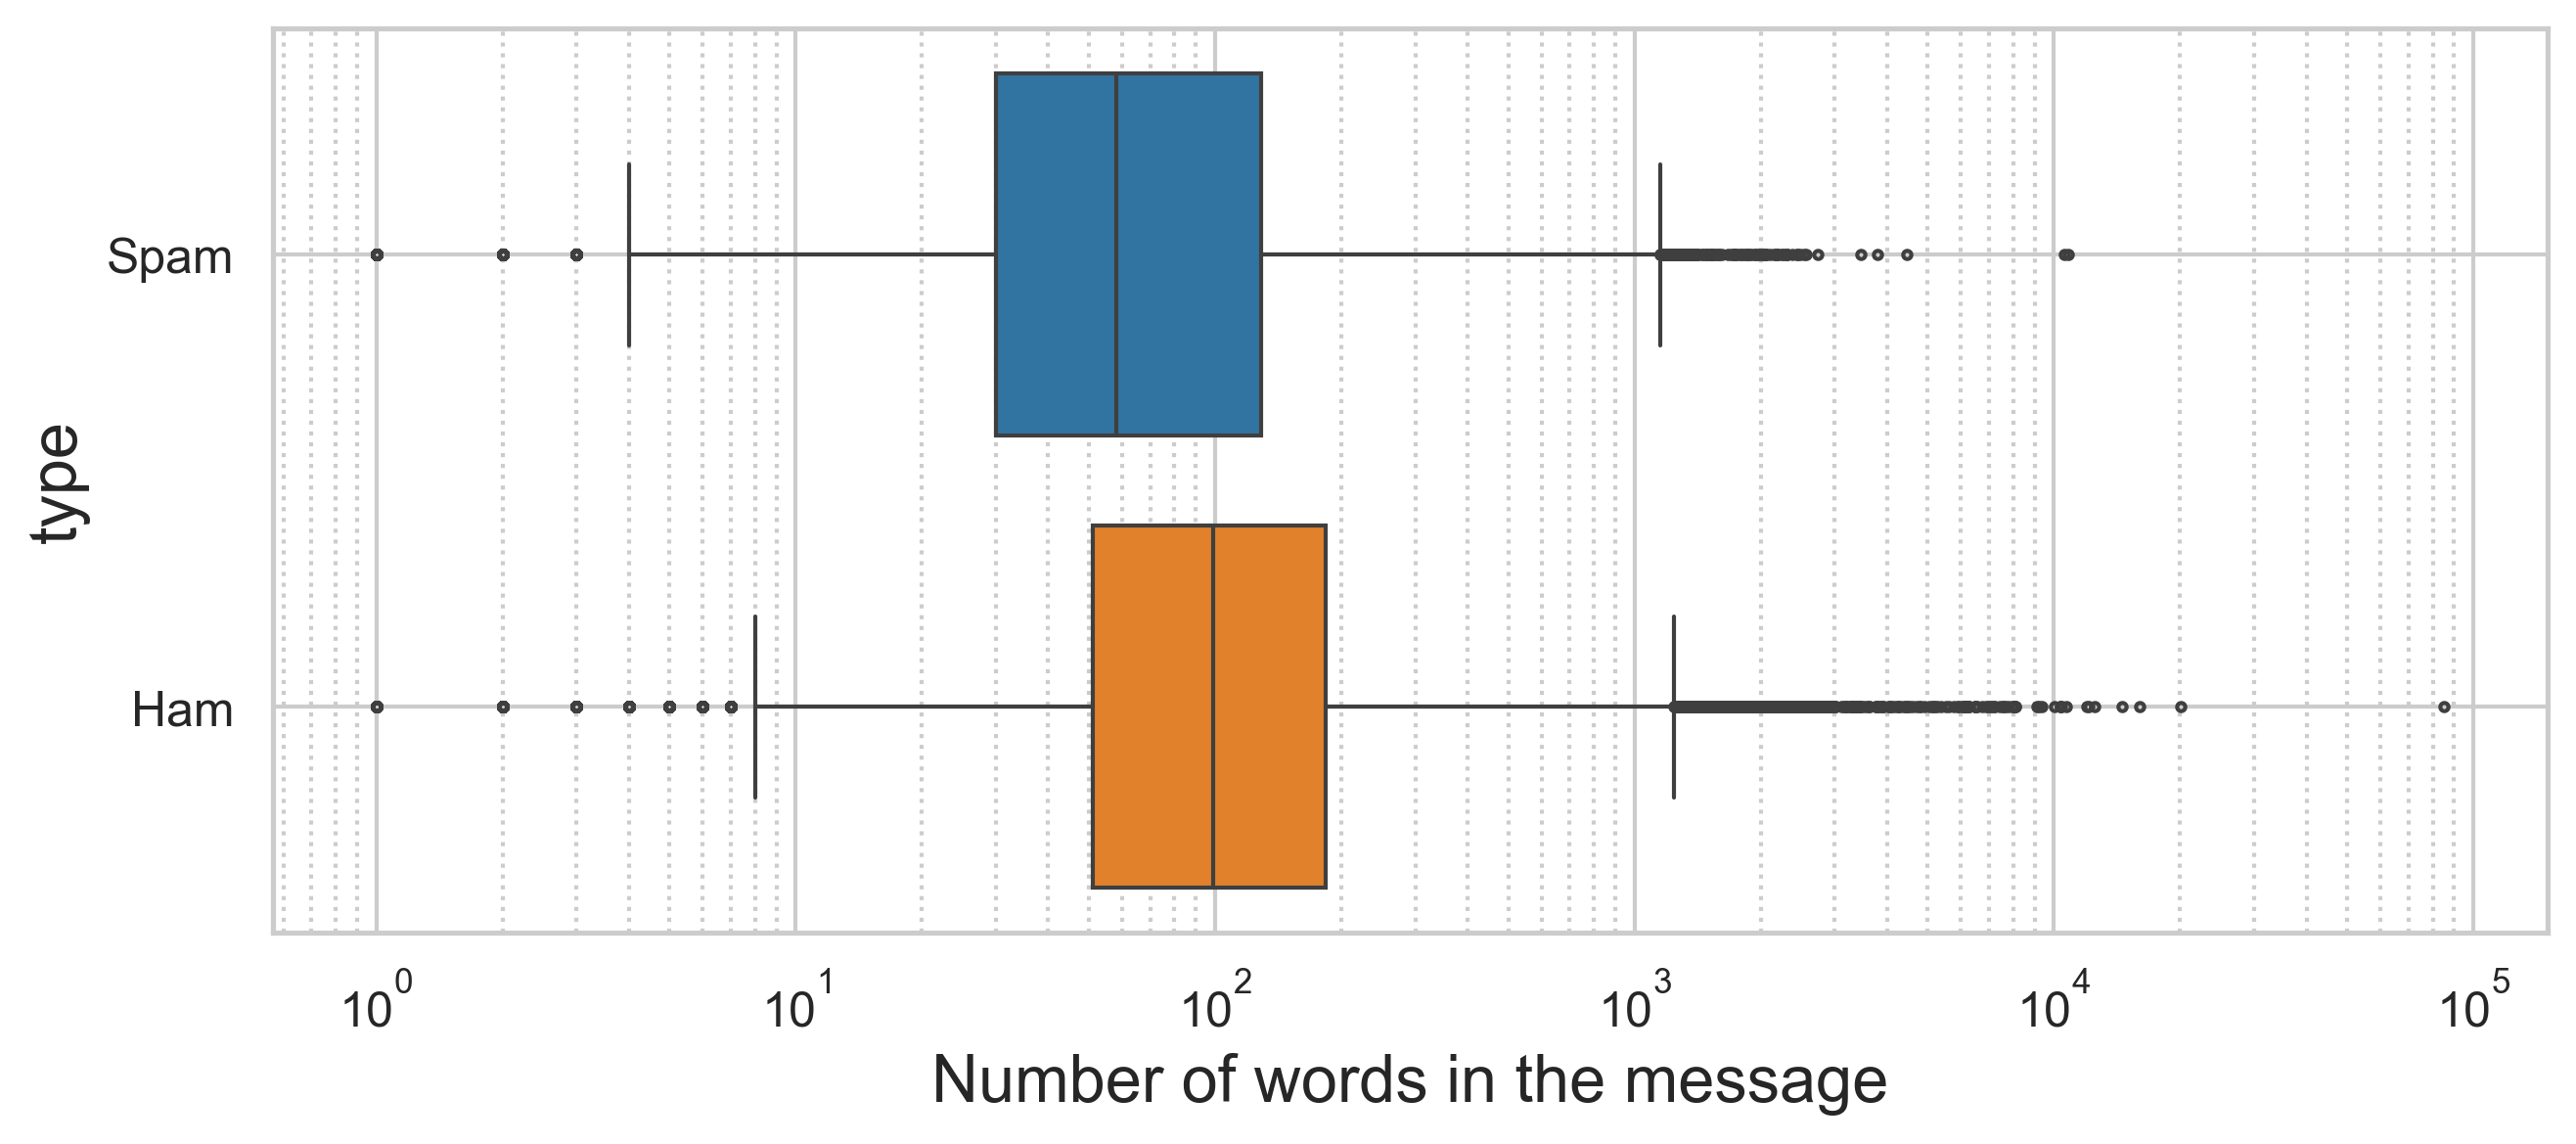

In [28]:
# histogram
plt.figure(figsize=(10,4))
ax = sns.histplot(
    data=df.assign(type=df.label.map({0: "Ham", 1: "Spam"}),word_counts=[len(x.split()) for x in df['email'].tolist()]),
    x="word_counts",
    hue="type",
    log_scale=True,
    bins=40,
    # kde=True
)
ax.grid(True, which="minor", axis='x', ls=":")
ax.grid(True, which="major", axis='x', ls="--")
ax.grid(True, which="major", axis='y', ls="-")
plt.xlabel("Number of words in the message (post-cleaning)")
ax.get_legend().set_title("Email Type")
plt.show()

# violin plot
plt.figure(figsize=(10,4))
ax = sns.boxplot(
    data=df.assign(type=df.label.map({0: "Ham", 1: "Spam"}),word_counts=[len(x.split()) for x in df['email'].tolist()]),
    x="word_counts",
    hue="type",
    y="type",
    log_scale=True,
    fliersize=2
    # bins=40,
    # kde=True
)
ax.grid(True, which="minor", axis='x', ls=":")
ax.grid(True, which="major", axis='x', ls="-")
ax.grid(True, which="major", axis='y', ls="-")
plt.xlabel("Number of words in the message (post-cleaning)")
plt.show()

### Random Forest

In [40]:
# instantiate a classifier: Random Forest Classifier
clf=RandomForestClassifier()

# learn the classifications on the train subset
clf.fit(X_train, y_train)

Training Score:  0.9961203151682195 0.9723786698621929


In [45]:
print("Training Score: ", clf.score(X_train, y_train), "\nTesting Score : ", clf.score(X_test, y_test))

Training Score:  0.9961203151682195 
Testing Score :  0.9723786698621929


In [30]:
# # Persisting the classifier
# import joblib

# # save
# joblib.dump(clf, "tfidf_rf_clf.pkl")
# # load
# #model_rf = joblib.load("model.pkl")

['tfidf_rf_clf.pkl']

In [50]:
y_predict = clf.predict(X_test)

accuracy = np.sum(y_test == y_predict) / len(y_test)

print(accuracy)
print(metrics.classification_report(y_test, y_predict))

0.9723786698621929
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      7906
           1       0.97      0.98      0.97      8784

    accuracy                           0.97     16690
   macro avg       0.97      0.97      0.97     16690
weighted avg       0.97      0.97      0.97     16690



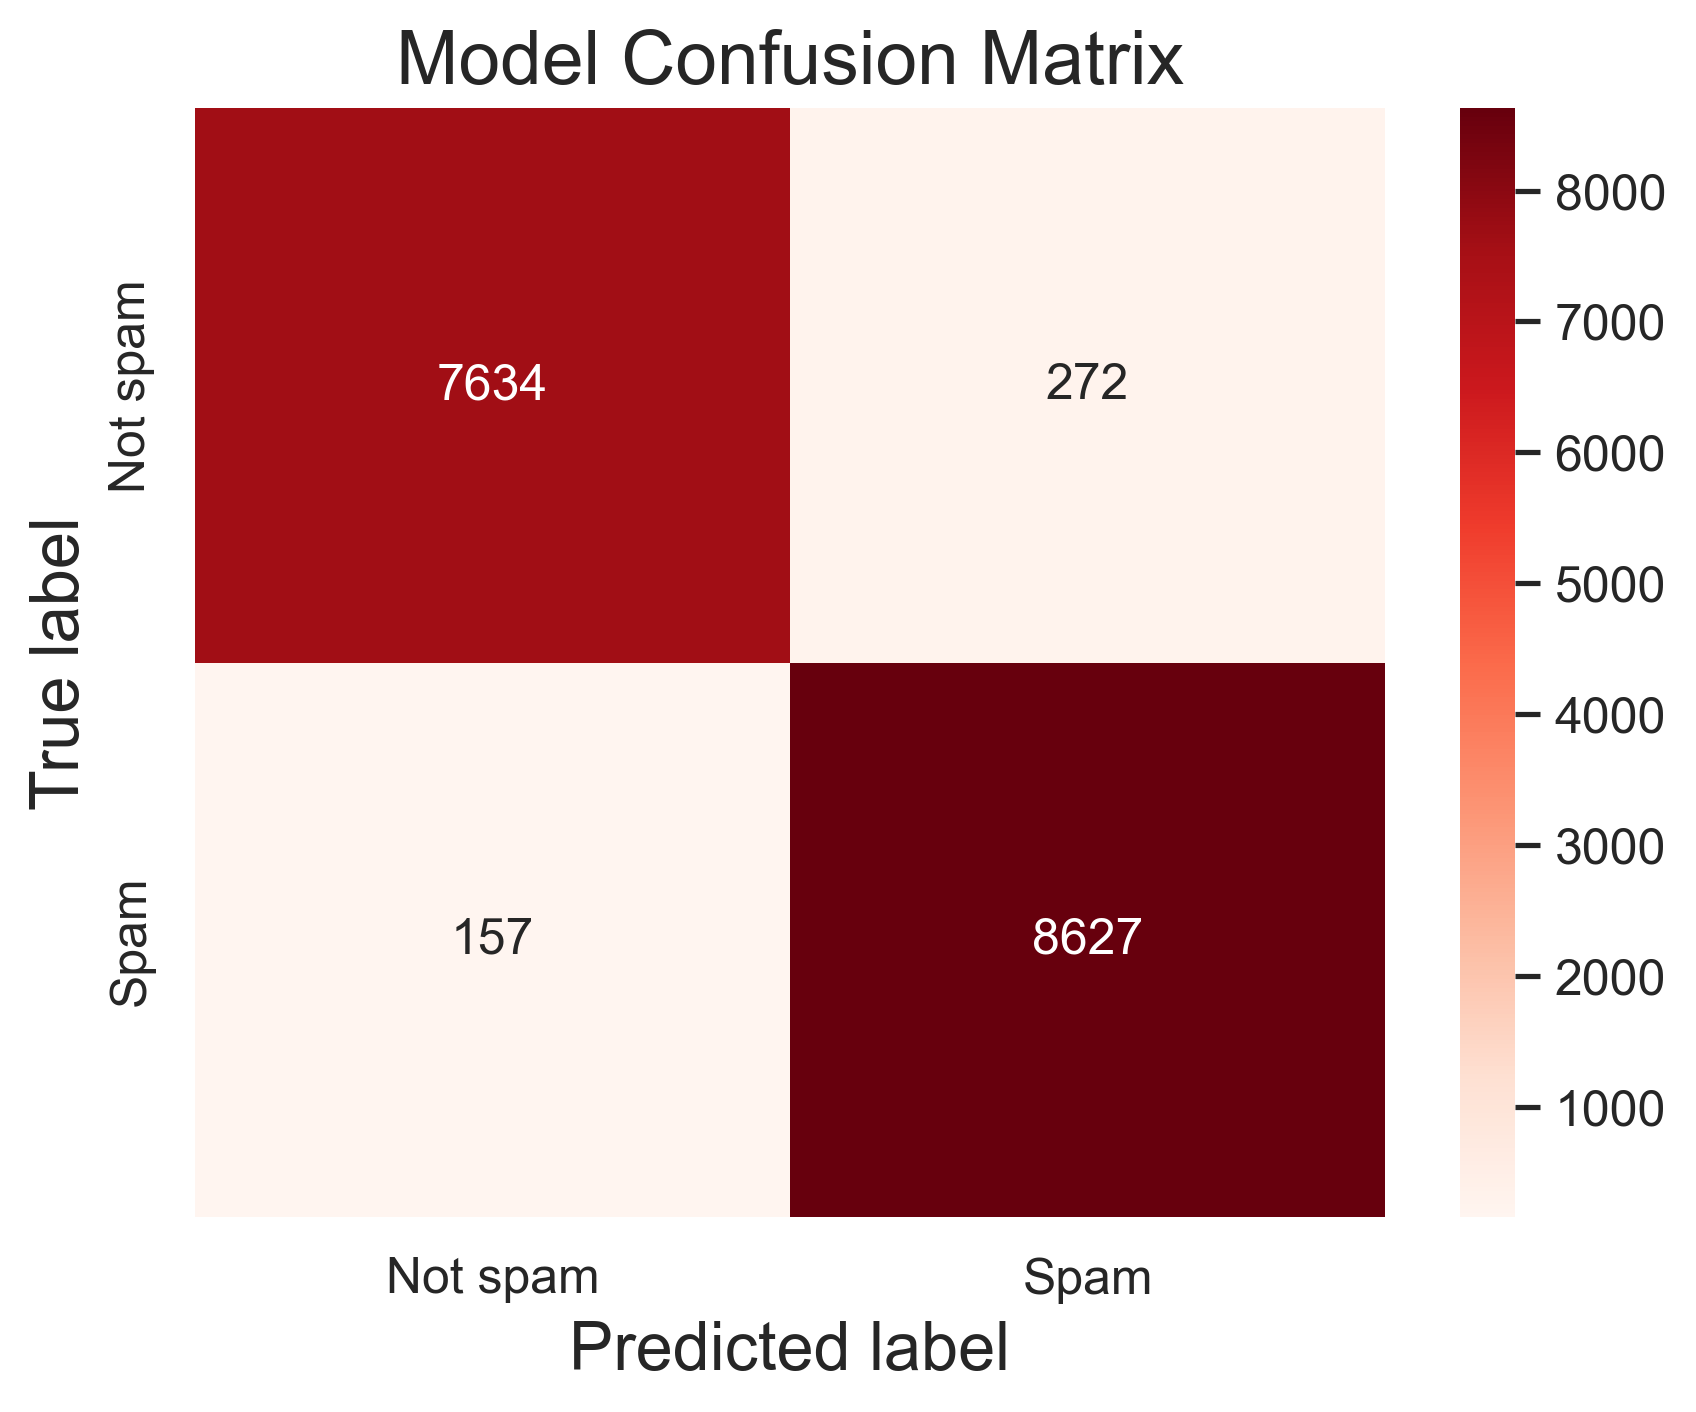

In [34]:
# generate confusion matrix figure
ticklabels=["Not spam", "Spam"]

cm = metrics.confusion_matrix(y_test, y_predict)
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=ticklabels, yticklabels=ticklabels)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
plt.title("Model Confusion Matrix")
plt.show()

### Random Forest - Demo

In [47]:
demo_text = widgets.Textarea(
    value='',
    placeholder='Enter your email message contents.',
    disabled=False,
    layout=widgets.Layout(width='100%', height='20rem')
)
submit_btn = widgets.Button(
    description='Submit',
    disabled=False
)
output = widgets.Output()

def predict_is_spam(text):
    if isinstance(text, str) is not True:
        raise ValueError('Provided input is not a string.')

    cleaned_text=preprocess(text)
    # print(cleaned_text)
    processed_text=tfidf_vec.transform([cleaned_text])
    prediction=clf.predict(processed_text)[0]
    probability=clf.predict_proba(processed_text)[0]
    return prediction, probability

def on_submit_clicked(b):
    result, probability = predict_is_spam(demo_text.value)
    with output:
        if result:
            print("The message is likely spam.")
            print(f"[RF Confidence: {probability[1]}]")
        else:
            print("The message is likely not spam.")
            print(f"[RF Confidence: {probability[0]}]")
    output.clear_output(wait=True)

submit_btn.on_click(on_submit_clicked)

display(demo_text, submit_btn, output)

Textarea(value='', layout=Layout(height='20rem', width='100%'), placeholder='Enter your email message contents…

Button(description='Submit', style=ButtonStyle())

Output()